In [240]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

In [241]:
ciphertext = "JGRMQOYGHMVBJWRWQFPWHGFFDQGFPFZRKBEEBJIZQQOCIBZKLFAFGQVFZFWWEOGWOPFGFHWOLPHLRLOLFDMFGQWBLWBWQOLKFWBYLBLYLFSFLJGRMQBOLWJVFPFWQVHQWFFPQOQVFPQOCFPOGFWFJIGFQVHLHLROQVFGWJVFPFOLFHGQVQVFILEOGQILHQFQGIQVVOSFAFGBWQVHQWIJVWJVFPFWHGFIWIHZZRQGBABHZOCGFHX"
english_letter_freq = {
    'Letter': list('ABCDEFGHIJKLMNOPQRSTUVWXYZ'),
    'Frequency': [8.2, 1.5, 2.8, 4.3, 12.7, 2.2, 2.0, 6.1, 7.0, 0.2, 0.8, 4.0, 2.4, 6.7, 1.5, 1.9, 0.1, 6.0, 6.3, 9.1, 2.8, 1.0, 2.4, 0.2, 2.0, 0.1]
}
english_freq = pd.DataFrame(english_letter_freq)
english_freq = english_freq.sort_values(by='Frequency', ascending=False).reset_index(drop=True)

common_digraphs = ['TH', 'HE', 'IN', 'ER', 'AN', 'RE', 'ED', 'ON', 'ES', 'ST']


In [242]:
def tabulate_freq(ciphertext: str) -> pd.DataFrame:
    char_counts = Counter(ciphertext)
    total_chars = len(ciphertext)
    freq = {char: (count / total_chars)*100 for char, count in char_counts.items()}
    freq_df = pd.DataFrame(list(freq.items()), columns=['Letter', 'Frequency'])
    freq_df = freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    return freq_df

def get_closest_chars(cipher_frequency_table: pd.DataFrame, english_freq: float) -> pd.Series:
    closest_row = cipher_frequency_table.loc[cipher_frequency_table['Frequency'].sub(english_freq).abs().idxmin()]
    return closest_row


def get_most_common_ngrams(ciphertext: str, n=2, top_n=10) -> pd.DataFrame:
    ngrams = [ciphertext[i:i+n] for i in range(len(ciphertext) - n + 1) if len(set(ciphertext[i:i+n])) == 3]
    ngram_counts = Counter(ngrams)
    ngram_df = pd.DataFrame(ngram_counts.items(), columns=['Ngram', 'Count'])
    ngram_df = ngram_df.sort_values(by='Count', ascending=False).reset_index(drop=True)
    return ngram_df.head(top_n)


def get_decryption_key(english_freq: pd.DataFrame, cipher_freq_table: pd.DataFrame):
    key = {}

    key['F'] = 'E'
    
    common_digrams = get_most_common_ngrams(ciphertext, n=2)
    common_trigrams = get_most_common_ngrams(ciphertext, n=3)
    the_trigram = common_trigrams[common_trigrams['Ngram'].str.endswith('F')].iloc[0]['Ngram'] 
    key[the_trigram[0]] = 'T'
    key[the_trigram[1]] = 'H'
    
    return key

def get_decrypted(ciphertext, key) -> dict:
    print(key)
    message = ciphertext
    for char in key:
        message = message.replace(key[char], char)
    return message
  



{'F': 'E', 'Q': 'T', 'V': 'H'}


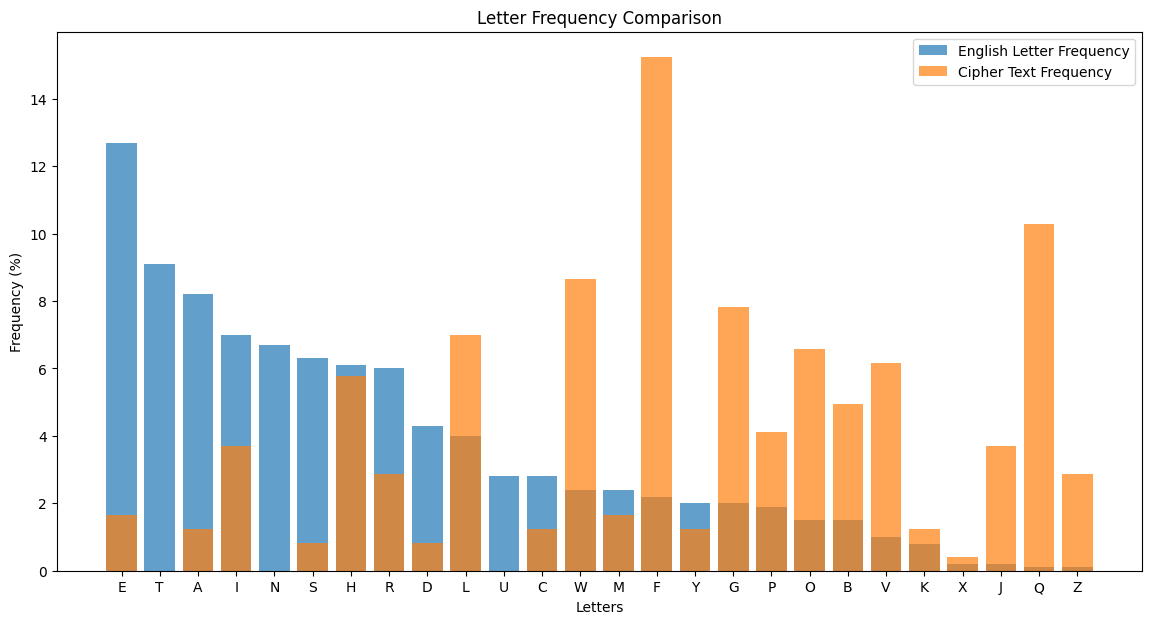

In [243]:
cipher_frequency_table =  tabulate_freq(ciphertext)
# print(cipher_frequency_table)
key = get_decryption_key(english_freq, cipher_frequency_table)
get_decrypted(ciphertext, key)

plt.figure(figsize=(14, 7))

# Plot English letter frequency
plt.bar(english_freq['Letter'], english_freq['Frequency'], alpha=0.7, label='English Letter Frequency')

# Plot cipher text letter frequency
plt.bar(cipher_frequency_table['Letter'], cipher_frequency_table['Frequency'], alpha=0.7, label='Cipher Text Frequency')

plt.xlabel('Letters')
plt.ylabel('Frequency (%)')
plt.title('Letter Frequency Comparison')
plt.legend()
plt.show()
